In [1]:
import numpy as np
import emcee
print("This version of emcee is:", emcee.__version__)
import sys
print("This version of Python is %s.%s.%s" % sys.version_info[:3])
from matplotlib import pyplot as plt
import scipy.stats 
from IPython.display import display, HTML

This version of emcee is: 2.2.1
This version of Python is 3.6.2


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 🎙| The MCMC Hammer

<b>The emcee module is a Python implemenation of the Affine-Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler, originally developed by Goodman & Weare.</b> 

<div style="display: flex; justify-content: row;">
    <img src="https://media.giphy.com/media/xDrn9oG797R96/giphy.gif">
</div>

Side quest: __[MC Hammer: U Can't Touch This (Official Video)](https://www.youtube.com/watch?v=otCpCn0l4Wo)__

This notebook closely follows the documentation provided below.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


<div class="alert alert-block alert-info">

### 📓 | References  

</div>

- __[Link to arXiv paper](https://arxiv.org/pdf/1202.3665.pdf)__

- __[Link to official documentation](https://emcee.readthedocs.io/en/v2.2.1/user/quickstart/)__

- "A Zero-Math Introduction to Markov Chain Monte Carlo Methods", Ben Shaver
    - __[Link to Medium article](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50)__ 


---

<div class="alert alert-block alert-info">

<b> 🔢  | Math sidenote </b>  

</div>


 <b>Affine space</b> 

"In mathematics, an affine space is a geometric structure that generalizes some of the properties of Euclidean spaces in such a way that these are independent of the concepts of distance and measure of angles, keeping only the properties related to parallelism and ratio of lengths for parallel line segments.

In an affine space, there is no distinguished point that serves as an origin. Hence, no vector has a fixed origin and no vector can be uniquely associated to a point. In an affine space, there are instead displacement vectors, also called translation vectors or simply translations, between two points of the space. Thus it makes sense to subtract two points of the space, giving a translation vector, but it does not make sense to add two points of the space. Likewise, it makes sense to add a displacement vector to a point of an affine space, resulting in a new point translated from the starting point by that vector.

Any vector space may be considered as an affine space, and this amounts to forgetting the special role played by the zero vector. In this case, the elements of the vector space may be viewed either as points of the affine space or as displacement vectors or translations. When considered as a point, the zero vector is called the origin. Adding a fixed vector to the elements of a linear subspace of a vector space produces an affine subspace. One commonly says that this affine subspace has been obtained by translating (away from the origin) the linear subspace by the translation vector. In finite dimensions, such an affine subspace is the solution set of an inhomogeneous linear system. The displacement vectors for that affine space are the solutions of the corresponding homogeneous linear system, which is a linear subspace. Linear subspaces, in contrast, always contain the origin of the vector space." (Thanks, wiki!) 
        
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 

## 2. Fitting a model to (noisy) data

### Approach #1: The generative probabilistic model 
---
This approach describes the probability of a dataset given a set of model parameters. Here, we're working with a linear model where the uncertainties given are actually underestimated by some constant fractional amount (❕). 

---

<div class="alert alert-block alert-warning">
    <b>❕ | Spoiler alert  <b/>
        </div>

<b> The generative probabilistic model only works when the error bars given are assumed to be: correct, Gaussian, and independent.</b> 

---

Starting with a synthetic dataset from this model: 

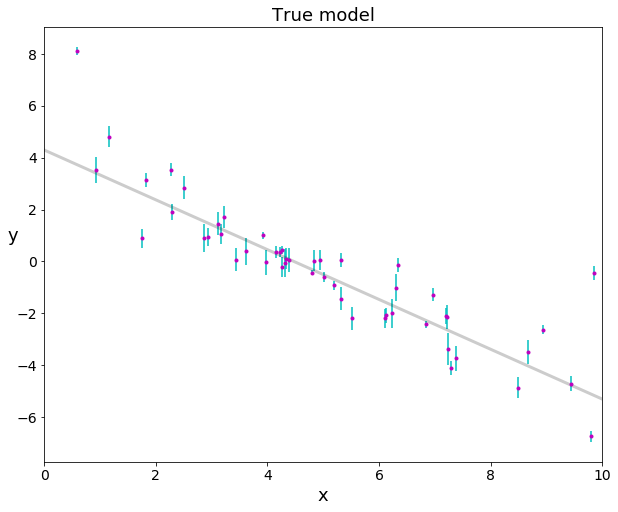

In [2]:
np.random.seed(123)

# True parameters 
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate synthetic data from the model 
N = 50 
x = np.sort(10*np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N) #y-error
y = m_true * x + b_true 
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.figure(figsize=(10,8))
plt.errorbar(x,y,yerr=yerr, fmt=".m",ecolor='c',capsize=0)
x0 = np.linspace(0,10,500)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.2, lw=3)
plt.xlim(0,10)
plt.xlabel("x", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.title("True model", fontsize= 18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

Given the underestimated uncertainties, the true model fit is not the best one. A standard way to fit this data is using linear least squares. 

In [3]:
A = np.vander(x,2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))
print("Least squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0,0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1,1])))

Least squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


---
<div class="alert alert-block alert-info">
    <b> 🐍 | Python sidenote  </b>
</div>

<b>np.vander(x, N=None, increasing=False)</b>

Generates a Vandermonde matrix. 

The columns of the output matrix are powers of the input vector. The order of the powers is determined by the increasing boolean argument. Specifically, when increasing is False, the i-th output column is the input vector raised element-wise to the power of N - i - 1. Such a matrix with a geometric progression in each row is named for Alexandre- Theophile Vandermonde.

---
Plotting our least squares solution against the true model:

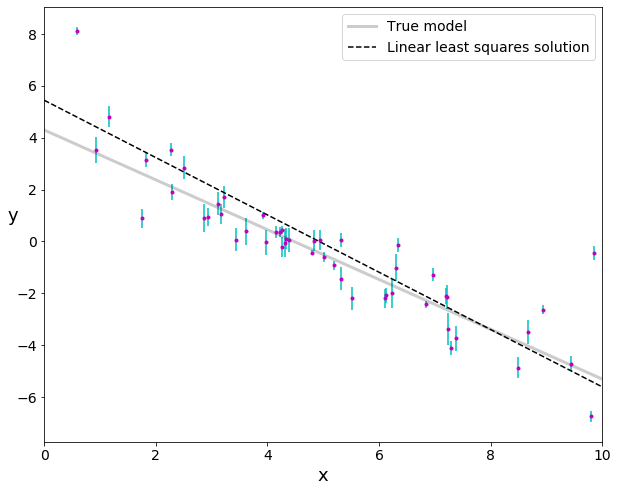

In [4]:
plt.figure(figsize=(10,8))
plt.errorbar(x,y,yerr=yerr, fmt=".m",ecolor='c',capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.2, lw=3, label="True model")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="Linear least squares solution")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

 It's pretty far off from our true model though...
 
 <div style="display: flex; justify-content: row;">
    <img src="https://media.giphy.com/media/119XyLewLGmT0k/giphy.gif">
</div>

But we anticipated this! Let's try another approach.

 <div style="display: flex; justify-content: row;">
    <img src="https://media.giphy.com/media/bKnEnd65zqxfq/giphy.gif">
</div>

---
### Approach #2: Maximum likelihood estimation
---
The least squares solution we found above is the maximum likelihood for a model given the correct error. Recall, however, that the error in this example has been underestimated. This means that the general case will not work for us, we need to take the likelihood function (📊) and optimize it numerically using scipy's optimize module. 

The likelihood function we will use is: 

\begin{equation*}
\textrm{ln} p(y|x,\sigma, m, b, f) = - \frac{1}{2} \sum_n \left( \frac{(y_n - m x_n- b)^2}{s^2_n} + \textrm{ln}(2\pi s_n^2)\right),
\end{equation*}

where 

\begin{equation*}
s_n^2  \sigma_n^2 + f^2(mx_n+b)^2.
\end{equation*}



---
<div class= "alert alert-box alert-info">
    <b> 📊 | Stats sidenote </b>
    </div>


A <b>likelihood function</b> is a Gaussian whose variance we know to be underestimated by some fractional amount $f$.  

---


Defining this function in code (note that we are using the log of $f$): 

In [5]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model**2*np.exp(2*log_f)
    return -0.5 * np.sum((y-model)**2/sigma2 + np.log(sigma2))

In [6]:
from scipy.optimize import minimize

np.random.seed(42)
n11 = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(n11, initial, args=(x,y,yerr))
m_ml, b_ml, log_f_ml = soln.x

#print("Maximum likelihood estimates:")
print("m = {0:0.3f}".format(m_ml))
print("b = {0:0.3f}".format(b_ml))
print("f = {0:0.3f}".format(np.exp(log_f_ml)))

m = -1.003
b = 4.528
f = 0.454


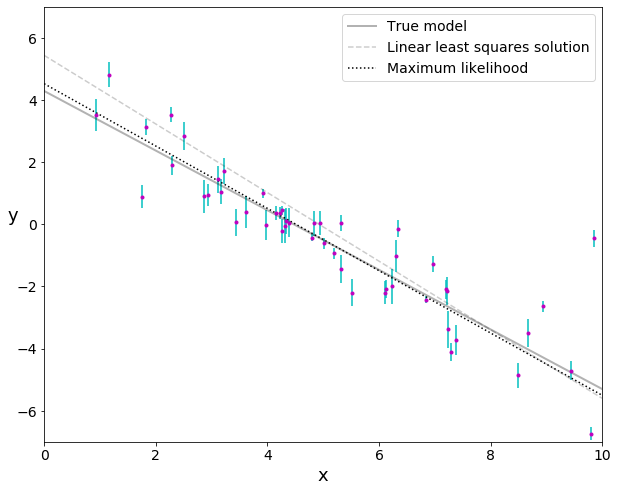

In [7]:
plt.figure(figsize=(10,8))
plt.errorbar(x,y,yerr=yerr, fmt=".m",ecolor='c',capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=2, label="True model")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k",  alpha=0.2, label="Linear least squares solution")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="Maximum likelihood")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.ylim(-7,7)
plt.xlabel("x", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

By using the minimize module, we managed to minimize the negative likelihood. We're getting there (look how much closer the ML solution matches the true model)! Now, how to esitmate the uncertanties on $m$ and $b$? And what is $f$??


<div style="display: flex; justify-content: row;">
    <img src="https://media.giphy.com/media/y3QOvy7xxMwKI/giphy.gif">
</div>


### Marginalization & uncertainty estimation

What makes [The] MCMC [Hammer] great, name asside, is that it allows you to find an estimate of a <b>posterior probability function </b> (📊) as well as marginalize over some "nuisance parameters" at the same time.  

---
<div class= "alert alert-box alert-info">
    <b> 📊 | Stats sidenote </b>
    </div>


A <b>posterior probability function</b> is the distribution of parameters consistent with a given dataset.  

---


In our maximum likelihood apporach, we had written out our likelihood function. What we need is the "prior" function in order to get the posterior probability function: 

\begin{equation*}
p(m,b,f|x,y,\sigma) \propto p(m,b,f)p(y|x,\sigma, m,b,f)
\end{equation*}

The prior function $p(m,b,f)$ encodes previous knowledge we have about our system (e.g., prior experiements, ranges that are physically acceptable). 

---

<div class = "alert alert-block alert-warning">
    ❕ | Important
    </div>

<b> You can't draw parameter samples from your likelihood function! Why? Because that function is a probability distribution over datasets. So while you can have representative datasets, you cannot draw parameter samples. </b>

---    

For the purpose of our example, we will use uniformative priors on $m$, $b$ and $f$ (which remember is actually the log of $f$): 

\begin{equation*}
    p(m)=
    \begin{cases}
      1/5.5, & \text{if}\ -5 < m < 1/2 \\
      0, & \text{otherwise}
    \end{cases}\end{equation*} 

In [8]:
def log_prior(theta): 
    m, b, log_f = theta
    if -5.0 < m <0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0: 
        return 0.0
    return -np.inf

Using this function with our log-probabilty function, we get: 

In [ ]:
def log_probability(theta, x,y,yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Now, let's sample this distribution with emcee.

We'll start with our walkers initialized in a small Gaussian ball around our maximum likelihood result, then run 5,000 MCMC steps.

 <div style="display: flex; justify-content: row;">
    <img src="https://media.giphy.com/media/11rIergnpiYpvW/giphy.gif">
</div>

In [ ]:
pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000)#, progress=True);

(array([[-1.05845582,  4.83908645, -0.72989666],
        [-0.94993168,  4.30451062, -0.91735235],
        [-1.22564195,  5.4561314 , -0.96904454],
        [-0.96365984,  4.35421675, -0.83080015],
        [-0.96789911,  4.33066341, -0.73775402],
        [-1.08552484,  4.7931804 , -0.9736668 ],
        [-0.92902013,  4.18359875, -0.71914554],
        [-1.07019305,  4.71194917, -0.79573846],
        [-0.94643955,  4.20698806, -0.43328909],
        [-0.95672664,  4.23942243, -0.91072988],
        [-0.99929965,  4.5821401 , -0.8988428 ],
        [-1.05959688,  4.8590696 , -0.54469157],
        [-1.0695827 ,  4.90763803, -0.87777916],
        [-1.04233342,  4.75349702, -0.90467062],
        [-1.13774357,  5.19955515, -0.85679477],
        [-1.00954573,  4.54530739, -0.81754373],
        [-0.98510957,  4.49366259, -0.66026737],
        [-0.90802079,  4.1077392 , -0.65283666],
        [-0.9753313 ,  4.34364589, -0.80321768],
        [-0.87521829,  3.9932199 , -0.60507091],
        [-1.171261  

So what did we accomplish? Let's take a look at the time series of the parameters in the chain, which can be accessed using the EnsembleSampler.get_chain() method (❕):

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.chain[:, :, :]
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

---

<div class="alert alert-block alert-warning">
    <b>❕ | Using pre-3.0 version  <b/>
        </div>

<b> Looks like we may need to update emcee to v3.0. The get_chain() function is not avaialble with v2. </b> 

---

In any case, we are still able to flatten the chain (discarding the first 50 steps) so that we have a flat list of samples to use for our corner plot (🐍).  

---
<div class="alert alert-block alert-info">
    <b> 🐍 | Python sidenote  </b>
</div>

<b>__[corner plot](https://corner.readthedocs.io/en/latest/)__</b>

"An illustrative representation of different projections of samples in high dimensional spaces. It is awesome. I promise.

This Python module uses matplotlib to visualize multidimensional samples using a scatterplot matrix. In these visualizations, each one- and two-dimensional projection of the sample is plotted to reveal covariances. corner was originally conceived to display the results of Markov Chain Monte Carlo simulations and the defaults are chosen with this application in mind but it can be used for displaying many qualitatively different samples."

---

### Results

#### Figure: Corner Plot

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1,ndim))
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
truths=[m_true, b_true, np.log(f_true)], figsize=(10,10))
fig.savefig("triangle.png")

<div style="display: flex; justify-content: row;">
    <img src="https://media.giphy.com/media/3o7abBP0nMjrdIvaCY/giphy.gif">
</div>

Pretty sweet, right?  

Not only does this plot visualize all of the covariances present between parameters, but the histograms along the diagonal also show the marginalized distribution for each parameter independently! 

And this is only one possible diagnostic tool! Another plot we can use is the projection of the results into the space of the observed data. Let's take a handful of samples from the chain and plot them on top of our (original) data points. 

#### Figure: Sample Projection

---

In [ ]:
xl = np.array([0, 10])
plt.figure(figsize=(10,8))

for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="c", alpha=0.1)

plt.errorbar(x,y,yerr=yerr, fmt=".m",ecolor='m',capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=1, lw=3, label="True model")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k",  alpha=0.2, label="Linear least squares solution")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="Maximum likelihood")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.ylim(-7,7)
plt.xlabel("x", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

As for our final numbers? Let's take a look: 

In [ ]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
zip(*np.percentile(samples, [16, 50, 84],
axis=0)))

print("MCMC values")
print("m_mcmc = {0:0.3f}".format(m_mcmc[0]))
print("b_mcmc = {0:0.3f}".format(b_mcmc[0]))
print("f_mcmc = {0:0.3f}".format(f_mcmc[0]))
print("------------------------")
print("Least likelihood values")
print("ml = {0:0.3f}".format(m_ml))
print("bl = {0:0.3f}".format(b_ml))
print("fl = {0:0.3f}".format(np.exp(log_f_ml)))
print("------------------------")
print("True values")
print("m = {0:0.3f}".format(m_true))
print("b = {0:0.3f}".format(b_true))
print("f = {0:0.3f}".format(f_true))


<div style="display: flex; justify-content: row;">
    <img src="https://media.giphy.com/media/Er43b5UCDYtrTDOaix/giphy.gif">
</div>

Not bad, MCMC! 